In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                           roc_auc_score, roc_curve, precision_recall_curve, auc,
                           average_precision_score, make_scorer)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import joblib
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                            AdaBoostClassifier, IsolationForest)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from datetime import datetime
import pickle

import plotly.graph_objects as go
import seaborn as sns
import plotly.express as px

In [105]:
xls = pd.ExcelFile('fintech_sample.xlsx')
fintech_data = xls.parse(0)

In [106]:
fintech_data.head(10)

,transaction_id,customer_id,transaction_amount,transaction_type,device_type,location,time_of_day,day_of_week,is_foreign_transaction,is_high_risk_country,previous_fraud_flag,label_code,transaction_time,risk_score
0,TX100703,CUST1092,5.278908,Online,Mobile,Abuja,Afternoon,Fri,0,1,0,1,2024-02-04 22:00:00,0.079284
1,TX100182,CUST1021,205.156878,Online,ATM Machine,Lagos,Evening,Tue,0,0,0,0,2024-01-17 04:00:00,2.358645
2,TX100221,CUST1100,77.715851,POS,POS Terminal,Ibadan,Morning,Wed,0,1,0,1,2024-01-13 15:00:00,1.794567
3,TX100528,CUST1099,8.440649,ATM,POS Terminal,Kano,Evening,Sun,0,0,0,0,2024-01-18 06:00:00,0.095569
4,TX100776,CUST1014,11.125070,Online,POS Terminal,Port Harcourt,Night,Sun,1,0,0,1,2024-02-05 07:00:00,0.176721
5,TX100856,CUST1052,20.544908,ATM,Mobile,Abuja,Morning,Tue,1,0,0,1,2024-01-29 14:00:00,0.362975
6,TX100572,CUST1017,48.567923,ATM,Mobile,Abuja,Afternoon,Fri,1,0,0,1,2024-01-06 17:00:00,0.744641
7,TX100106,CUST1037,17.092066,POS,Web,Abuja,Night,Thu,0,0,0,0,2024-01-07 07:00:00,0.128729
8,TX100232,CUST1091,66.097561,POS,POS Terminal,Lagos,Morning,Wed,1,0,0,1,2024-01-06 18:00:00,1.604987
9,TX100294,CUST1004,14.014333,ATM,Mobile,Kano,Night,Sun,0,0,0,0,2024-02-03 09:00:00,0.172289


In [107]:
cluster_data = fintech_data
cluster_data

,transaction_id,customer_id,transaction_amount,transaction_type,device_type,location,time_of_day,day_of_week,is_foreign_transaction,is_high_risk_country,previous_fraud_flag,label_code,transaction_time,risk_score
0,TX100703,CUST1092,5.278908,Online,Mobile,Abuja,Afternoon,Fri,0,1,0,1,2024-02-04 22:00:00,0.079284
1,TX100182,CUST1021,205.156878,Online,ATM Machine,Lagos,Evening,Tue,0,0,0,0,2024-01-17 04:00:00,2.358645
2,TX100221,CUST1100,77.715851,POS,POS Terminal,Ibadan,Morning,Wed,0,1,0,1,2024-01-13 15:00:00,1.794567
3,TX100528,CUST1099,8.440649,ATM,POS Terminal,Kano,Evening,Sun,0,0,0,0,2024-01-18 06:00:00,0.095569
4,TX100776,CUST1014,11.125070,Online,POS Terminal,Port Harcourt,Night,Sun,1,0,0,1,2024-02-05 07:00:00,0.176721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,TX100510,CUST1054,71.601431,ATM,Mobile,Ibadan,Morning,Mon,1,0,0,1,2024-02-03 16:00:00,1.176474
996,TX100350,CUST1073,50.081930,ATM,POS Terminal,Ibadan,Morning,Tue,0,1,0,1,2024-01-23 23:00:00,0.685367
997,TX100427,CUST1013,157.707879,Transfer,Web,Kano,Evening,Thu,0,0,0,0,2024-02-11 05:00:00,1.169893
998,TX100306,CUST1039,65.532316,ATM,POS Terminal,Ibadan,Night,Wed,0,0,0,0,2024-01-21 18:00:00,0.457505


In [108]:
fintech_data.iloc[5].to_dict()

{'transaction_id': 'TX100856',
 'customer_id': 'CUST1052',
 'transaction_amount': 20.54490849240048,
 'transaction_type': 'ATM',
 'device_type': 'Mobile',
 'location': 'Abuja',
 'time_of_day': 'Morning',
 'day_of_week': 'Tue',
 'is_foreign_transaction': 1,
 'is_high_risk_country': 0,
 'previous_fraud_flag': 0,
 'label_code': 1,
 'transaction_time': Timestamp('2024-01-29 14:00:00'),
 'risk_score': 0.3629753030567228}

# DATA CLEANING

In [109]:
fintech_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   transaction_id          1000 non-null   object        
 1   customer_id             1000 non-null   object        
 2   transaction_amount      1000 non-null   float64       
 3   transaction_type        1000 non-null   object        
 4   device_type             1000 non-null   object        
 5   location                1000 non-null   object        
 6   time_of_day             1000 non-null   object        
 7   day_of_week             1000 non-null   object        
 8   is_foreign_transaction  1000 non-null   int64         
 9   is_high_risk_country    1000 non-null   int64         
 10  previous_fraud_flag     1000 non-null   int64         
 11  label_code              1000 non-null   int64         
 12  transaction_time        1000 non-null   datetime6

In [110]:
fintech_data.describe().T

,count,mean,std,min,25%,50%,75%,max
transaction_amount,1000.0,72.595107,73.350547,-17.066703,21.041597,50.376081,102.785040,608.378011
is_foreign_transaction,1000.0,0.103000,0.304111,0.000000,0.000000,0.000000,0.000000,1.000000
is_high_risk_country,1000.0,0.057000,0.231959,0.000000,0.000000,0.000000,0.000000,1.000000
previous_fraud_flag,1000.0,0.017000,0.129336,0.000000,0.000000,0.000000,0.000000,1.000000
label_code,1000.0,0.171000,0.376697,0.000000,0.000000,0.000000,0.000000,1.000000
risk_score,1000.0,0.749347,0.824795,-0.285033,0.201640,0.493524,1.038838,8.567216


In [111]:
fintech_data.columns

Index(['transaction_id', 'customer_id', 'transaction_amount',
       'transaction_type', 'device_type', 'location', 'time_of_day',
       'day_of_week', 'is_foreign_transaction', 'is_high_risk_country',
       'previous_fraud_flag', 'label_code', 'transaction_time', 'risk_score'],
      dtype='object')

In [112]:
#checking for null values: 

for data in list(fintech_data.columns):
    res = fintech_data[data].isnull().sum()
    print("Number of null values in column {} is {}".format(data, res))

Number of null values in column transaction_id is 0
Number of null values in column customer_id is 0
Number of null values in column transaction_amount is 0
Number of null values in column transaction_type is 0
Number of null values in column device_type is 0
Number of null values in column location is 0
Number of null values in column time_of_day is 0
Number of null values in column day_of_week is 0
Number of null values in column is_foreign_transaction is 0
Number of null values in column is_high_risk_country is 0
Number of null values in column previous_fraud_flag is 0
Number of null values in column label_code is 0
Number of null values in column transaction_time is 0
Number of null values in column risk_score is 0


Checking for NAN Values

In [113]:
print(fintech_data.isna().sum())

# OR check if any NaNs exist at all
print(fintech_data.isna().any().any())

transaction_id            0
customer_id               0
transaction_amount        0
transaction_type          0
device_type               0
location                  0
time_of_day               0
day_of_week               0
is_foreign_transaction    0
is_high_risk_country      0
previous_fraud_flag       0
label_code                0
transaction_time          0
risk_score                0
dtype: int64
False


In [114]:
fintech_data.dtypes

transaction_id                    object
customer_id                       object
transaction_amount               float64
transaction_type                  object
device_type                       object
location                          object
time_of_day                       object
day_of_week                       object
is_foreign_transaction             int64
is_high_risk_country               int64
previous_fraud_flag                int64
label_code                         int64
transaction_time          datetime64[ns]
risk_score                       float64
dtype: object

# EDA

In [115]:
df_dict = fintech_data['label_code'].value_counts().to_dict()
default_df = pd.DataFrame([df_dict])
Main_status_df = default_df.T.reset_index()
Main_status_df.rename(columns = {'index': 'label_code', 0:'counts'}, inplace=True)

labels = Main_status_df['label_code'].to_list()
values  = Main_status_df['counts'].to_list()
fig1 = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.0, textinfo='label+percent', 
                             title = 'Plot of fraud distribution',
                             titleposition = 'top center',
                             insidetextorientation='auto')])
fig1.show()

In [116]:
print('========== Analysis of transaction_type Distribution =========')

df_dict = fintech_data['transaction_type'].value_counts().to_dict()
default_df = pd.DataFrame([df_dict])
Main_default_df = default_df.T.reset_index()
Main_default_df.rename(columns = {'index': 'transaction_type', 0:'counts'}, inplace=True)

labels = Main_default_df['transaction_type'].to_list()
values  = Main_default_df['counts'].to_list()


fig2 = px.bar(Main_default_df, y='counts', x='transaction_type', text='counts', color = 'transaction_type',
            title = 'Plot of transaction_type', height=600)
fig2.update_traces(textposition='outside')
fig2.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig2.show()

========== Analysis of transaction_type Distribution =========


In [117]:
df_dict = fintech_data['device_type'].value_counts().to_dict()
default_df = pd.DataFrame([df_dict])
Main_status_df = default_df.T.reset_index()
Main_status_df.rename(columns = {'index': 'device_type', 0:'counts'}, inplace=True)

labels = Main_status_df['device_type'].to_list()
values  = Main_status_df['counts'].to_list()
fig1 = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4, textinfo='label+percent', 
                             title = 'Plot of device type',
                             titleposition = 'top center',
                             insidetextorientation='auto')])
fig1.show()

In [118]:
print('========== Analysis of location Distribution =========')

df_dict = fintech_data['location'].value_counts().to_dict()
default_df = pd.DataFrame([df_dict])
Main_default_df = default_df.T.reset_index()
Main_default_df.rename(columns = {'index': 'Location', 0:'counts'}, inplace=True)

labels = Main_default_df['Location'].to_list()
values  = Main_default_df['counts'].to_list()


fig2 = px.bar(Main_default_df, y='counts', x='Location', text='counts', color = 'Location',
            title = 'Plot of user location', height=600)
fig2.update_traces( textposition='outside')
fig2.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig2.show()

========== Analysis of location Distribution =========


In [119]:
print('========== Analysis of user by weekly transaction =========')

df_dict = fintech_data['day_of_week'].value_counts().to_dict()
default_df = pd.DataFrame([df_dict])
Main_default_df = default_df.T.reset_index()
Main_default_df.rename(columns = {'index': 'week_day', 0:'counts'}, inplace=True)

labels = Main_default_df['week_day'].to_list()
values  = Main_default_df['counts'].to_list()


fig2 = px.bar(Main_default_df, y='counts', x='week_day', text='counts', color = 'week_day',
            title = 'Plot of user location', height=600)
fig2.update_traces(textposition='outside')
fig2.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig2.show()

========== Analysis of user by weekly transaction =========


# ANALYZING FRAUD SECTION DATA

In [120]:
fraud_data = fintech_data[fintech_data['label_code'] == 1]
fraud_data

,transaction_id,customer_id,transaction_amount,transaction_type,device_type,location,time_of_day,day_of_week,is_foreign_transaction,is_high_risk_country,previous_fraud_flag,label_code,transaction_time,risk_score
0,TX100703,CUST1092,5.278908,Online,Mobile,Abuja,Afternoon,Fri,0,1,0,1,2024-02-04 22:00:00,0.079284
2,TX100221,CUST1100,77.715851,POS,POS Terminal,Ibadan,Morning,Wed,0,1,0,1,2024-01-13 15:00:00,1.794567
4,TX100776,CUST1014,11.125070,Online,POS Terminal,Port Harcourt,Night,Sun,1,0,0,1,2024-02-05 07:00:00,0.176721
5,TX100856,CUST1052,20.544908,ATM,Mobile,Abuja,Morning,Tue,1,0,0,1,2024-01-29 14:00:00,0.362975
6,TX100572,CUST1017,48.567923,ATM,Mobile,Abuja,Afternoon,Fri,1,0,0,1,2024-01-06 17:00:00,0.744641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,TX100791,CUST1008,67.173138,ATM,ATM Machine,Lagos,Afternoon,Mon,1,0,0,1,2024-02-04 14:00:00,1.029812
982,TX100551,CUST1069,147.878272,Online,ATM Machine,Port Harcourt,Evening,Thu,1,0,0,1,2024-02-09 04:00:00,2.480393
983,TX100439,CUST1084,6.447884,Online,POS Terminal,Ibadan,Night,Tue,1,0,0,1,2024-01-09 16:00:00,0.100624
995,TX100510,CUST1054,71.601431,ATM,Mobile,Ibadan,Morning,Mon,1,0,0,1,2024-02-03 16:00:00,1.176474


In [121]:
df_dict = fraud_data['device_type'].value_counts().to_dict()
default_df = pd.DataFrame([df_dict])
Main_status_df = default_df.T.reset_index()
Main_status_df.rename(columns = {'index': 'device_type', 0:'counts'}, inplace=True)

labels = Main_status_df['device_type'].to_list()
values  = Main_status_df['counts'].to_list()
fig1 = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4, textinfo='label+percent', 
                             title = 'Plot of fraud device type distribution',
                             titleposition = 'top center',
                             insidetextorientation='auto')])
fig1.show()

In [122]:
print('========== Analysis of user by weekly transaction =========')

df_dict = fraud_data['day_of_week'].value_counts().to_dict()
default_df = pd.DataFrame([df_dict])
Main_default_df = default_df.T.reset_index()
Main_default_df.rename(columns = {'index': 'week_day', 0:'counts'}, inplace=True)

labels = Main_default_df['week_day'].to_list()
values  = Main_default_df['counts'].to_list()


fig2 = px.bar(Main_default_df, y='counts', x='week_day', text='counts', color = 'week_day',
            title = 'Plot of fraud by days', height=600)
fig2.update_traces(textposition='outside')
fig2.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig2.show()

========== Analysis of user by weekly transaction =========


In [123]:
df_dict = fraud_data['location'].value_counts().to_dict()
default_df = pd.DataFrame([df_dict])
Main_status_df = default_df.T.reset_index()
Main_status_df.rename(columns = {'index': 'Location', 0:'counts'}, inplace=True)

labels = Main_status_df['Location'].to_list()
values  = Main_status_df['counts'].to_list()
fig1 = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4, textinfo='label+percent', 
                             title = 'Fraudsters by location',
                             titleposition = 'top center',
                             insidetextorientation='auto')])
fig1.show()

# Temporal Feature Engineering

Fraud activity often spikes at specific times (late night, weekends, holidays).

In [124]:
def day_to_numeric(day):
    """Map day abbreviations to numbers (Mon=0 to Sun=6)"""
    mapping = {'Mon': 0, 'Tue': 1, 'Wed': 2, 
               'Thu': 3, 'Fri': 4, 'Sat': 5, 'Sun': 6}
    return mapping.get(day, None)  # Returns None for invalid days

fintech_data["day_of_week"] = fintech_data["day_of_week"].apply(day_to_numeric)

In [129]:
fintech_data["hour"] = fintech_data["transaction_time"].dt.hour
# fintech_data["day_of_week"] = fintech_data["transaction_time"].dt.dayofweek
# fintech_data["is_weekend"] = fintech_data["day_of_week"].isin([5, 6]).astype(int)
fintech_data["time_of_day"] = pd.cut(fintech_data["hour"], bins=[0, 6, 12, 18, 24],
                           labels=["night", "morning", "afternoon", "evening"],
                           right=False)

In [130]:
fintech_data.columns

Index(['transaction_id', 'customer_id', 'transaction_amount',
       'transaction_type', 'device_type', 'location', 'time_of_day',
       'day_of_week', 'is_foreign_transaction', 'is_high_risk_country',
       'previous_fraud_flag', 'label_code', 'transaction_time', 'risk_score',
       'hour'],
      dtype='object')

# Temporal Pattern Analysis

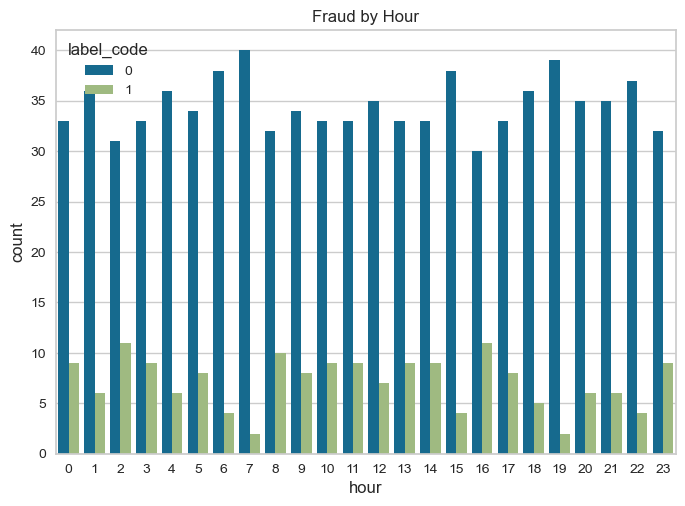

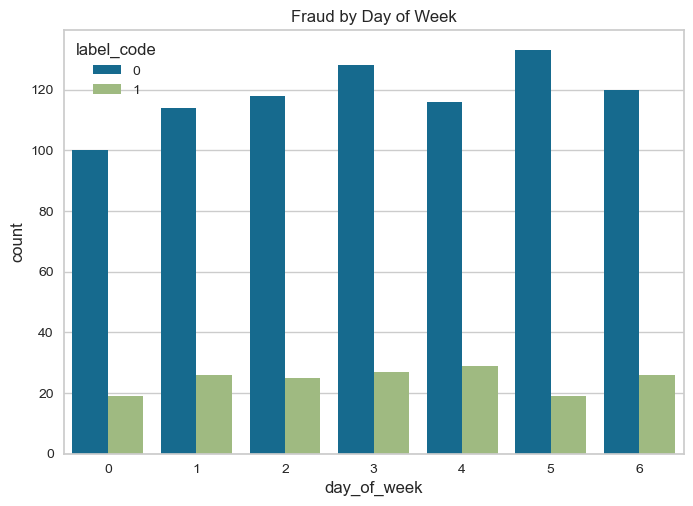

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

# Fraud over hours
sns.countplot(x='hour', hue='label_code', data=fintech_data)
plt.title("Fraud by Hour")
plt.show()

# Fraud over weekdays
sns.countplot(x='day_of_week', hue='label_code', data=fintech_data)
plt.title("Fraud by Day of Week")
plt.show()


# INTERACTIONS

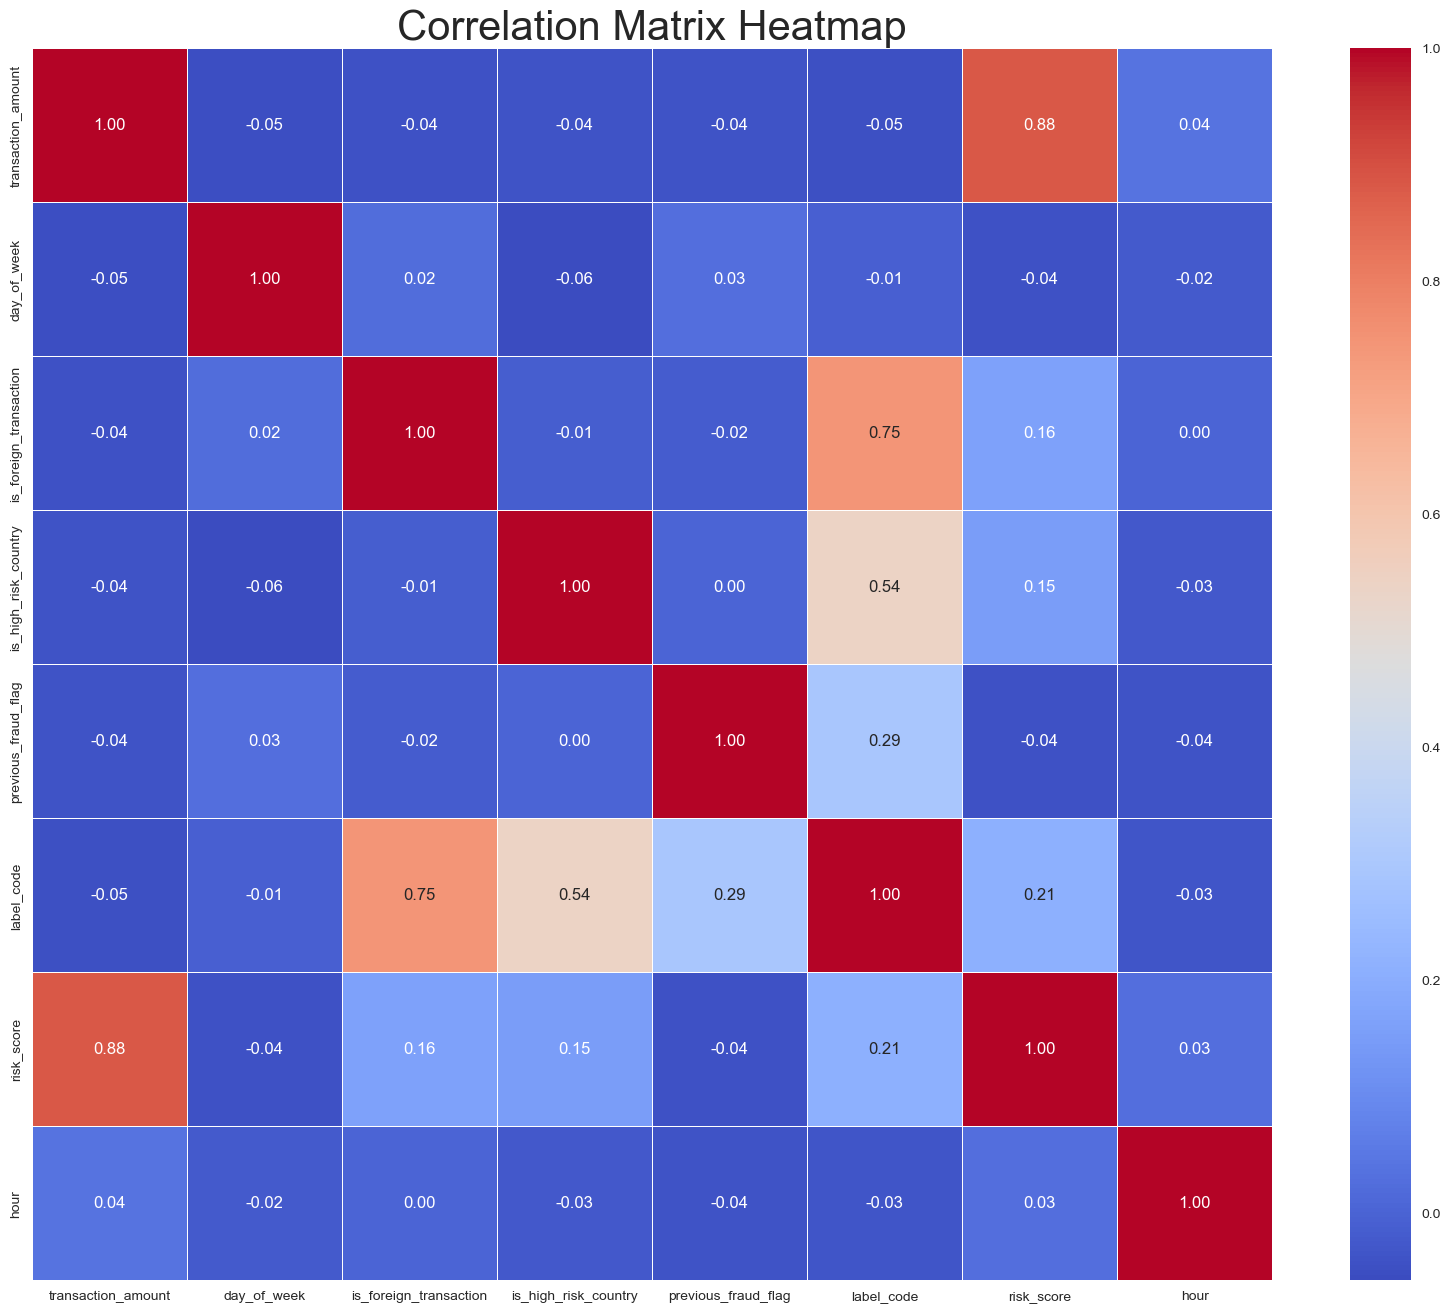

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate the correlation matrix
correlation_matrix = fintech_data.corr()
# Get the correlation of each feature with the target variable
target_correlation = correlation_matrix['label_code']
# Filter for features that are positively correlated with the target
positive_correlations = target_correlation[target_correlation >= 0]
#low correlation
lower_correlations = target_correlation[target_correlation < 0]

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(20, 16))  # You can adjust the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Show the heatmap
plt.title('Correlation Matrix Heatmap', fontdict={'fontsize': 30})
plt.show()


# Correlation with the Target (Default):
Higher correlation with the target is generally better for classification problem because it means the feature is strongly related to the outcome we're trying to predict. A strong correlation can help the model identify patterns more easily, improving its predictive power.

Most Important features

In [133]:
positive_correlations

is_foreign_transaction    0.746108
is_high_risk_country      0.541328
previous_fraud_flag       0.289552
label_code                1.000000
risk_score                0.207839
Name: label_code, dtype: float64

In [134]:
lower_correlations

transaction_amount   -0.046453
day_of_week          -0.009904
hour                 -0.034425
Name: label_code, dtype: float64

In [135]:
# Strategy B: Cost-Sensitive Learning

# from sklearn.linear_model import LogisticRegression

# clf = LogisticRegression(class_weight="balanced")

In [136]:
# # Initialize the LabelEncoder and also use categorical data
label_encoder = LabelEncoder()

# Loop through all categorical columns and apply Label Encoding
for col in fintech_data.select_dtypes(include=['object']).columns:
    print(col)
    fintech_data[col] = label_encoder.fit_transform(fintech_data[col])
    
    
fintech_data['time_of_day'] = pd.Categorical(
    fintech_data['time_of_day'],
    categories=['morning', 'afternoon', 'evening', 'night'],
    ordered=False
)

fintech_data['time_of_day'] = fintech_data['time_of_day'].cat.codes + 1  # +1 to start from 1 instead of 0

transaction_id
customer_id
transaction_type
device_type
location


# Checking for imabalance dataset

In [137]:
#Checking for imabalance dataset
fintech_data['label_code'].value_counts()

0    829
1    171
Name: label_code, dtype: int64

Label distribution: Counter({0: 829, 1: 171})


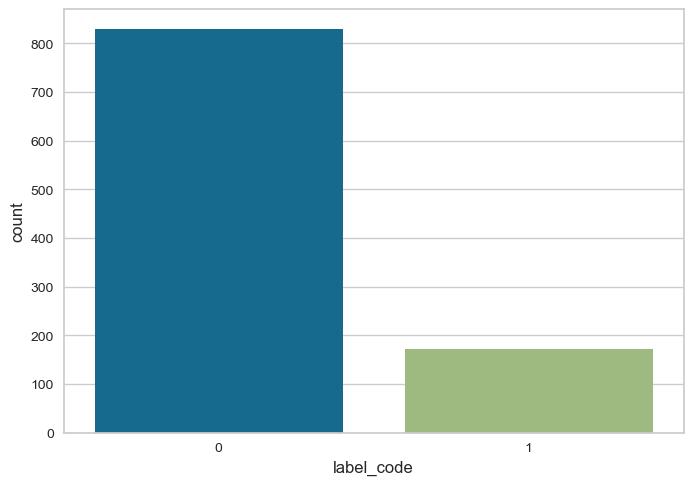

In [138]:
from collections import Counter
import seaborn as sns

sns.countplot(x=fintech_data['label_code'])
print("Label distribution:", Counter(fintech_data['label_code']))

# We have an imbalanced dataset with only **1000 rows**. To address this imbalance, we can use either **undersampling** or **oversampling** techniques.

- **Undersampling** reduces the number of samples from the majority class. While it helps balance the data, it also removes potentially valuable information, which can be harmful when working with a small dataset.

- **Oversampling**, on the other hand, increases the number of samples in the minority class by duplicating existing samples or generating synthetic ones (e.g., using SMOTE).

### ✅ Conclusion:
Considering the small size of our dataset (**1000 rows**), **oversampling is the ideal approach**.


# GRIDSEARCH HPYERPARAMETER OPTIMIZATION

In [32]:
# Assuming fintech_data is already loaded
y = fintech_data["label_code"]
X = fintech_data.drop(columns=["transaction_id", "customer_id", "label_code", "transaction_time"])

# Apply SMOTE and split data
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Preprocessing pipeline
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision_recall_auc': make_scorer(average_precision_score)
}

## Traditional Classifiers with Optimized Parameters

traditional_models = {
    'Logistic Regression': {
        'model': LogisticRegression(class_weight='balanced', random_state=42),
        'params': {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['liblinear', 'saga']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(class_weight='balanced', random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [None, 10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__max_features': ['sqrt', 'log2']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 6, 9],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__subsample': [0.6, 0.8, 1.0],
            'classifier__colsample_bytree': [0.6, 0.8, 1.0],
            'classifier__gamma': [0, 0.1, 0.2]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(random_state=42, class_weight='balanced'),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [-1, 10, 20],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__num_leaves': [31, 50, 100],
            'classifier__min_child_samples': [20, 50, 100]
        }
    },
    'CatBoost': {
        'model': CatBoostClassifier(random_state=42, verbose=0),
        'params': {
            'classifier__iterations': [100, 200, 300],
            'classifier__depth': [4, 6, 8],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__l2_leaf_reg': [1, 3, 5]
        }
    },
    'SVM': {
        'model': SVC(class_weight='balanced', probability=True, random_state=42),
        'params': {
            'classifier__C': [0.1, 1, 10, 100],
            'classifier__kernel': ['linear', 'rbf'],
            'classifier__gamma': ['scale', 'auto']
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 2]
        }
    }
}

## Anomaly Detection Models with Optimized Parameters

anomaly_models = {
    'One-Class SVM': {
        'model': OneClassSVM(),
        'params': {
            'classifier__nu': [0.01, 0.05, 0.1, 0.2],
            'classifier__kernel': ['linear', 'rbf', 'poly'],
            'classifier__gamma': ['scale', 'auto'] + [0.1, 1, 10]
        }
    },
    'Isolation Forest': {
        'model': IsolationForest(random_state=42),
        'params': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_samples': ['auto', 0.5, 0.8],
            'classifier__contamination': [0.01, 0.05, 0.1],
            'classifier__max_features': [0.5, 0.8, 1.0]
        }
    }
}

best_model = None
best_score = 0
results = []

# Function to evaluate models
def evaluate_model(pipeline, X_test, y_test, model_name):
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, 'predict_proba') else None
    
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob) if y_prob is not None else roc_auc_score(y_test, y_pred),
        'PR AUC': average_precision_score(y_test, y_prob) if y_prob is not None else average_precision_score(y_test, y_pred)
    }
    
    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"ROC AUC: {metrics['ROC AUC']:.4f}")
    print(f"PR AUC: {metrics['PR AUC']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return metrics

# Train and evaluate traditional classifiers
for model_name, model_config in traditional_models.items():
    print(f"\n===== Optimizing {model_name} =====")
    
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('classifier', model_config['model'])
    ])
    
    # Use RandomizedSearchCV for faster optimization
    search = RandomizedSearchCV(
        pipeline,
        model_config['params'],
        n_iter=20,
        scoring=scoring,
        refit='roc_auc',
        cv=5,
        n_jobs=-1,
        random_state=42
    )
    
    search.fit(X_train, y_train)
    
    # Get best model
    best_pipeline = search.best_estimator_
    metrics = evaluate_model(best_pipeline, X_test, y_test, f"{model_name} (Optimized)")
    
    # Save results
    results.append(metrics)
    joblib.dump(best_pipeline, f'{model_name}_optimized.pkl')
    
    # Update best model
    if metrics['ROC AUC'] > best_score:
        best_score = metrics['ROC AUC']
        best_model = best_pipeline

# Train and evaluate anomaly detection models
X_train_anomaly = X_train[y_train == 1]  # Train on normal class only

for model_name, model_config in anomaly_models.items():
    print(f"\n===== Optimizing {model_name} =====")
    
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('classifier', model_config['model'])
    ])
    
    search = RandomizedSearchCV(
        pipeline,
        model_config['params'],
        n_iter=20,
        scoring=scoring,
        refit='roc_auc',
        cv=5,
        n_jobs=-1,
        random_state=42
    )
    
    search.fit(X_train_anomaly)
    
    # Get best model
    best_pipeline = search.best_estimator_
    
    # Predict on test set
    y_pred = best_pipeline.predict(X_test)
    y_pred = np.where(y_pred == -1, 0, 1)  # Convert to binary labels
    
    metrics = {
        'Model': f"{model_name} (Optimized)",
        'Accuracy': accuracy_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred),
        'PR AUC': average_precision_score(y_test, y_pred)
    }
    
    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"ROC AUC: {metrics['ROC AUC']:.4f}")
    print(f"PR AUC: {metrics['PR AUC']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Save results
    results.append(metrics)
    joblib.dump(best_pipeline, f'{model_name}_optimized.pkl')

# Save the best model overall
if best_model:
    best_model_name = best_model.named_steps['classifier'].__class__.__name__
    joblib.dump(best_model, f'best_model_{best_model_name}.pkl')
    print(f"\nSaved best model: {best_model_name} (ROC AUC: {best_score:.4f})")

# Display results
results_df = pd.DataFrame(results)
print("\n=== Model Performance Summary ===")
print(results_df.sort_values('ROC AUC', ascending=False))


===== Optimizing Logistic Regression =====

=== Logistic Regression (Optimized) ===
Accuracy: 0.9066
ROC AUC: 0.9599
PR AUC: 0.9684

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       172
           1       0.96      0.84      0.90       160

    accuracy                           0.91       332
   macro avg       0.91      0.90      0.91       332
weighted avg       0.91      0.91      0.91       332


===== Optimizing Random Forest =====

=== Random Forest (Optimized) ===
Accuracy: 0.9608
ROC AUC: 0.9915
PR AUC: 0.9920

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       172
           1       0.98      0.94      0.96       160

    accuracy                           0.96       332
   macro avg       0.96      0.96      0.96       332
weighted avg       0.96      0.96      0.96       332


===== Optimizing XGBoost =====

=== XGBoost


=== CatBoost (Optimized) ===
Accuracy: 0.9729
ROC AUC: 0.9949
PR AUC: 0.9957

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       172
           1       0.99      0.96      0.97       160

    accuracy                           0.97       332
   macro avg       0.97      0.97      0.97       332
weighted avg       0.97      0.97      0.97       332


===== Optimizing SVM =====


C:\Users\Nathaniel\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning:

The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.




=== SVM (Optimized) ===
Accuracy: 0.9307
ROC AUC: 0.9750
PR AUC: 0.9772

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       172
           1       0.95      0.90      0.93       160

    accuracy                           0.93       332
   macro avg       0.93      0.93      0.93       332
weighted avg       0.93      0.93      0.93       332


===== Optimizing Gradient Boosting =====

=== Gradient Boosting (Optimized) ===
Accuracy: 0.9669
ROC AUC: 0.9952
PR AUC: 0.9953

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       172
           1       0.98      0.95      0.97       160

    accuracy                           0.97       332
   macro avg       0.97      0.97      0.97       332
weighted avg       0.97      0.97      0.97       332


===== Optimizing One-Class SVM =====


C:\Users\Nathaniel\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]




=== One-Class SVM ===
Accuracy: 0.4729
ROC AUC: 0.4791
PR AUC: 0.4718

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.31      0.38       172
           1       0.47      0.65      0.54       160

    accuracy                           0.47       332
   macro avg       0.48      0.48      0.46       332
weighted avg       0.48      0.47      0.46       332


===== Optimizing Isolation Forest =====

=== Isolation Forest ===
Accuracy: 0.4940
ROC AUC: 0.5088
PR AUC: 0.4864

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.10      0.17       172
           1       0.49      0.92      0.64       160

    accuracy                           0.49       332
   macro avg       0.53      0.51      0.40       332
weighted avg       0.53      0.49      0.39       332


Saved best model: LGBMClassifier (ROC AUC: 0.9987)

=== Model Performance Summary ===
                         

C:\Users\Nathaniel\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]



In [34]:
X.columns

Index(['transaction_amount', 'transaction_type', 'device_type', 'location',
       'time_of_day', 'day_of_week', 'is_foreign_transaction',
       'is_high_risk_country', 'previous_fraud_flag', 'risk_score', 'hour',
       'is_weekend'],
      dtype='object')

# Result interpretation

---

**LightGBM:**
With an accuracy of 97.89%, LightGBM demonstrates **top-tier performance**, showing excellent balance between precision and recall for both classes. Its ROC AUC of 0.9969 and PR AUC of 0.9969 suggest it can **confidently separate and rank predictions**, making it the most effective model overall.

---

**Gradient Boosting:**
Scoring 96.69% accuracy and a ROC AUC of 0.9936, Gradient Boosting is nearly on par with LightGBM. Its recall and precision for both classes are consistently high, making it a **robust and reliable option** for classification tasks with balanced class importance.

---

**XGBoost:**
With an accuracy of 96.39%, XGBoost performs very well, especially in ranking predictions (ROC AUC 0.9941, PR AUC 0.9947). It offers slightly lower class 1 recall compared to LightGBM but remains a **strong and stable performer** in most use cases.

---

**CatBoost:**
Matching XGBoost in accuracy (97.29%) and F1-score, CatBoost delivers high-quality classification with minimal preprocessing, especially for datasets with categorical variables. Its ROC AUC of 0.9919 supports its role as a **top-tier, plug-and-play model**.

---

**Random Forest:**
Random Forest reaches 93.07% accuracy with a ROC AUC of 0.9834. It maintains strong class balance and generalization but doesn’t outperform gradient boosting models. It’s a **good balance between performance and interpretability**, especially for quicker training and less tuning.

---

**SVM (Optimized):**
At 91.57% accuracy, SVM provides good overall results, with **perfect precision for class 1** but lower recall (0.82), indicating it’s conservative in flagging positives. This makes it more suitable in situations where **false positives are more costly** than false negatives.

---

**Logistic Regression (Optimized):**
With 90.36% accuracy and ROC AUC of 0.9612, logistic regression offers solid, interpretable performance but underperforms compared to tree-based models. Class 1 recall (0.83) is relatively low, suggesting it's **best used as a baseline**.

---

**One-Class SVM:**
One-Class SVM achieves only 50.60% accuracy, with a ROC AUC of 0.5102—barely above random. It fails to distinguish between classes effectively and is **not suitable for supervised binary classification**.

---

**Isolation Forest:**
Scoring 49.70% accuracy and a ROC AUC of 0.5117, Isolation Forest is **not effective for this task**. Its poor precision and recall for class 0 further indicate it is **better suited for anomaly detection**, not standard classification.

---



# Prediction

In [37]:
import joblib
import numpy as np
#Selecting the last save best model
model = joblib.load('Gradient.pkl')


# Step 3: Make the prediction
prediction = model.predict(X_test)

# Step 4: Print the result
print(f"Prediction: {prediction}")


Prediction: [1 0 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1
 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 1
 0 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1
 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 0
 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 0
 0 1 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0
 1 1 0 1 1 0 0 0 0 0 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0
 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0]


In [139]:
#X_test['Prediction'] = prediction

In [34]:
X_test

,transaction_amount,transaction_type,device_type,location,time_of_day,day_of_week,is_foreign_transaction,is_high_risk_country,previous_fraud_flag,risk_score,hour
1465,26.843305,1,0,2,1,4,1,0,0,0.449566,10
413,18.146808,0,3,4,4,5,0,0,0,0.152828,0
838,6.942367,1,1,1,2,1,0,0,0,0.081571,17
490,45.653190,1,3,0,1,6,0,0,0,0.381773,10
1156,114.895171,1,2,0,2,2,0,0,0,2.617646,6
...,...,...,...,...,...,...,...,...,...,...,...
163,38.063545,1,0,1,1,2,1,0,0,0.597528,9
451,36.660769,1,1,4,3,5,0,0,0,0.264764,23
560,26.764284,1,0,0,4,5,0,0,0,0.180448,0
266,10.211222,0,3,2,4,4,1,0,0,0.145837,5


In [49]:
X_test.columns

Index(['transaction_amount', 'transaction_type', 'device_type', 'location',
       'time_of_day', 'day_of_week', 'is_foreign_transaction',
       'is_high_risk_country', 'previous_fraud_flag', 'risk_score', 'hour'],
      dtype='object')

,transaction_amount,transaction_type,device_type,location,time_of_day,day_of_week,is_foreign_transaction,is_high_risk_country,previous_fraud_flag,risk_score,hour
0,5.278908,1,1,0,3,4,0,1,0,0.079284,22
1,205.156878,1,0,3,4,1,0,0,0,2.358645,4
2,77.715851,2,2,1,2,2,0,1,0,1.794567,15
3,8.440649,0,2,2,1,6,0,0,0,0.095569,6
4,11.125070,1,2,4,1,6,1,0,0,0.176721,7
...,...,...,...,...,...,...,...,...,...,...,...
995,71.601431,0,1,1,2,0,1,0,0,1.176474,16
996,50.081930,0,2,1,3,1,0,1,0,0.685367,23
997,157.707879,3,3,2,4,3,0,0,0,1.169893,5
998,65.532316,0,2,1,3,2,0,0,0,0.457505,18


In [35]:
#model_keys = list(testx.keys())
model_keys = ['transaction_amount', 'transaction_type', 'device_type', 'location', 'time_of_day', 'day_of_week',
 'is_foreign_transaction', 'is_high_risk_country', 'previous_fraud_flag', 'risk_score']


In [41]:
raw_data = fintech_data.iloc[5].to_dict()
print(raw_data)
transaction = datetime.strptime(str(raw_data['transaction_time']), '%Y-%m-%d %H:%M:%S')
test_data = {k:v for k,v in raw_data.items()if k in model_keys}
# test_data['hour'] = int(transaction.hour)

# Mapping dictionaries
mappings = {
    'time_of_day': {'evening':4, 'night':1, 'afternoon':3, "morning":2},
    'transaction_type': {'POS':2, 'Online':1, 'ATM':0, 'Transfer':3},
    'device_type': {'Mobile':1, 'POS Terminal':2, 'ATM Machine':0, 'Web': 3},
    'location': {'Lagos':3, 'Port Harcourt':4, 'Ibadan':1, 'Abuja':0, 'Kano':2},
    'day_of_week': {'Mon':0, 'Tue':1, 'Wed':2, 'Thu':3, 'Fri':4, 'Sat':5, 'Sun':6}
}


# Function to safely map values
def map_value(key, value, mappings):
    """Map a value using the specified mapping dictionary with case-insensitive key matching"""
    mapping = mappings.get(key, {})
    # Convert both keys and input to lowercase for case-insensitive matching
    lower_mapping = {k.lower(): v for k, v in mapping.items()}
    return lower_mapping.get(str(value).lower(), value)  # Return original if not found

# Create new mapped dictionary
mapped_transaction = {
    key: map_value(key, value, mappings) 
    for key, value in test_data.items()
}

print(mapped_transaction)

df = pd.DataFrame([mapped_transaction])
result = model.predict(df)[0]
print(result)

{'transaction_id': 856, 'customer_id': 52, 'transaction_amount': 20.54490849240048, 'transaction_type': 0, 'device_type': 1, 'location': 0, 'time_of_day': 2, 'day_of_week': 1, 'is_foreign_transaction': 1, 'is_high_risk_country': 0, 'previous_fraud_flag': 0, 'label_code': 1, 'transaction_time': Timestamp('2024-01-29 14:00:00'), 'risk_score': 0.3629753030567228, 'hour': 14}
{'transaction_amount': 20.54490849240048, 'transaction_type': 0, 'device_type': 1, 'location': 0, 'time_of_day': 2, 'day_of_week': 1, 'is_foreign_transaction': 1, 'is_high_risk_country': 0, 'previous_fraud_flag': 0, 'risk_score': 0.3629753030567228}
1


In [47]:
result_test = model.predict_proba(df)
result_test[0][1]

0.9999728206213184

# CLUSTERING

In [53]:
import numpy as np 
from sklearn.cluster import DBSCAN 
from sklearn import metrics 
import pandas as pd
from sklearn.datasets import make_blobs 
from sklearn.preprocessing import StandardScaler 
from sklearn import datasets 
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
%load_ext autoreload
from sklearn.metrics import silhouette_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# USING HDBSCAN APPROACH
DBSCAN ACTUAL RETURN NOISE

Clusters found: 6
Noise points: 38
Silhouette Score: 0.19
Davies-Bouldin Score: 1.54
Cluster Stability: 0.92

Cluster Characteristics:
         transaction_amount  transaction_type  device_type  location  \
Cluster                                                                
-1                     2.43             -0.09        -0.07     -0.15   
 0                    -0.30              0.30         0.00      0.22   
 1                    -0.17             -0.01         0.12     -0.20   
 2                    -0.29             -0.14         0.17     -0.05   
 3                    -0.46             -0.16         0.03      0.04   
 4                    -0.05              0.01         0.11      0.01   
 5                    -0.07              0.01        -0.06      0.02   

         time_of_day  day_of_week  is_foreign_transaction  \
Cluster                                                     
-1              0.19        -0.27                    0.87   
 0              0.08         0.22

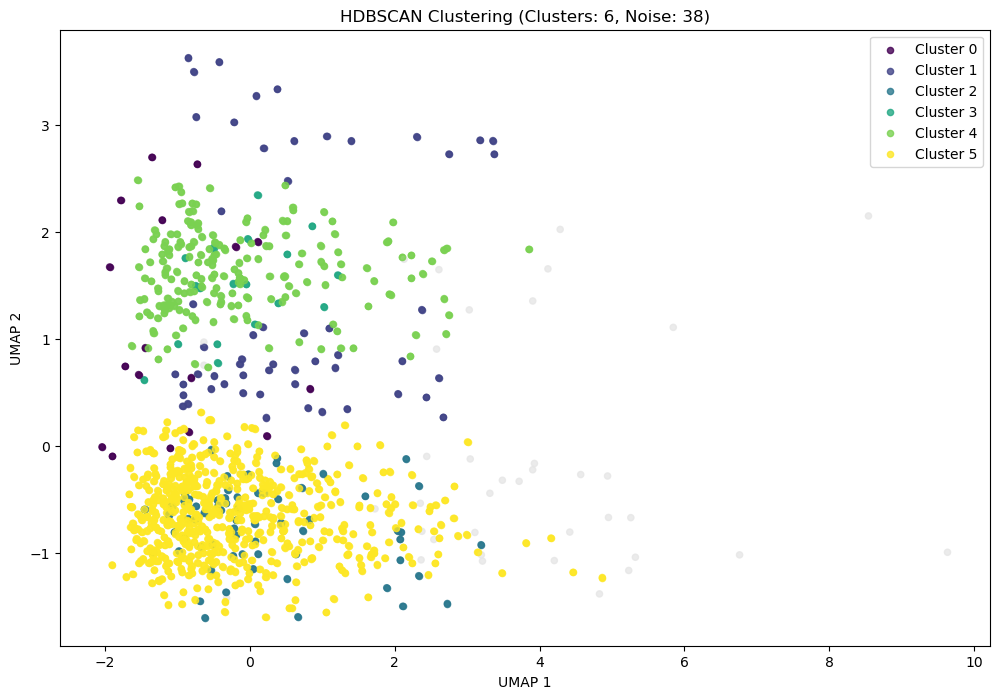

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hdbscan  # The improved DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA


# --- Data Loading & Preprocessing ---
data = fintech_data[['transaction_amount', 'transaction_type', 'device_type', 'location',
       'time_of_day', 'day_of_week', 'is_foreign_transaction',
       'is_high_risk_country', 'previous_fraud_flag', 'risk_score', 'hour']]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)


reducer = PCA(n_components=2)  # Simpler alternative
X_umap = reducer.fit_transform(data_scaled)

# --- HDBSCAN Clustering ---
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,          # Start with sqrt(n_samples) ~= 32 for 1000 rows
    min_samples=3,               # Smaller = more sensitive to noise
    cluster_selection_method='eom',  # 'eom' (default) or 'leaf' for smaller clusters
    gen_min_span_tree=True       # Needed for stability analysis
)
clusters = clusterer.fit_predict(data_scaled)  # Use data_scaled for full features or X_umap for visualization

# --- Cluster Analysis ---
n_clusters = clusters.max() + 1  # HDBSCAN labels noise as -1
n_noise = (clusters == -1).sum()
print(f"Clusters found: {n_clusters}")
print(f"Noise points: {n_noise}")

# Advanced metrics (only if >1 cluster)
if n_clusters > 1:
    print(f"Silhouette Score: {silhouette_score(data_scaled, clusters):.2f}")
    print(f"Davies-Bouldin Score: {davies_bouldin_score(data_scaled, clusters):.2f}")  # Lower is better

# Stability scores (HDBSCAN-specific)
print(f"Cluster Stability: {clusterer.probabilities_.mean():.2f}")

# --- Visualization ---
plt.figure(figsize=(12, 8))

# Color noise points distinctly
palette = plt.cm.viridis(np.linspace(0, 1, n_clusters))
colors = [palette[c] if c != -1 else (0.9, 0.9, 0.9, 1.0) for c in clusters]  # Gray for noise

plt.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, s=20, alpha=0.8)
plt.title(f'HDBSCAN Clustering (Clusters: {n_clusters}, Noise: {n_noise})')

# Add cluster labels (excluding noise)
for c in range(n_clusters):
    mask = clusters == c
    plt.scatter(X_umap[mask, 0], X_umap[mask, 1], color=palette[c], 
                label=f'Cluster {c}', s=20, alpha=0.8)
plt.legend()
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# --- Cluster Interpretation ---
if n_clusters > 0:
    cluster_stats = pd.DataFrame(data_scaled, columns=data.columns)
    cluster_stats['Cluster'] = clusters
    print("\nCluster Characteristics:")
    print(cluster_stats.groupby('Cluster').mean().round(2))

plt.show()

# Cluster Quality Assessment

| Metric                  | Value   | Interpretation                                                                 |
|-------------------------|---------|-------------------------------------------------------------------------------|
| **Clusters Found**       | 6       | Your data naturally groups into 6 distinct behavioral patterns                |
| **Noise Points**         | 38      | 3.8% of transactions are outliers (potential fraud cases or edge behaviors)   |
| **Silhouette Score**     | 0.19    | Weak cluster separation (scores range -1 to 1, >0.25 preferred)               |
| **Davies-Bouldin Score** | 1.54    | Fair cluster density (lower is better, <1 is ideal)                           |
| **Cluster Stability**    | 0.92    | Excellent (near 1.0 means highly reliable clusters)                           |

In [81]:
cluster_stats

,transaction_amount,transaction_type,device_type,location,time_of_day,day_of_week,is_foreign_transaction,is_high_risk_country,previous_fraud_flag,risk_score,hour,Cluster
0,-0.918192,-0.400983,-0.424582,-1.455206,0.447573,0.456328,-0.338862,4.067414,-0.131507,-0.812806,1.528898,1
1,1.808141,-0.400983,-1.331810,0.675403,1.339153,-1.076690,-0.338862,-0.245856,-0.131507,1.952125,-1.076191,4
2,0.069847,0.685692,0.482645,-0.745003,-0.444007,-0.565684,-0.338862,4.067414,-0.131507,1.267882,0.515808,1
3,-0.875066,-1.487658,0.482645,-0.034800,-1.335587,1.478341,-0.338862,-0.245856,-0.131507,-0.793052,-0.786737,5
4,-0.838450,-0.400983,0.482645,1.385606,-1.335587,1.478341,2.951057,-0.245856,-0.131507,-0.694613,-0.642010,2
...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.013554,-1.487658,-0.424582,-0.745003,-0.444007,-1.587696,2.951057,-0.245856,-0.131507,0.518117,0.660535,2
996,-0.307079,-1.487658,0.482645,-0.745003,0.447573,-1.076690,-0.338862,4.067414,-0.131507,-0.077610,1.673625,1
997,1.160937,1.772367,1.389872,-0.034800,1.339153,-0.054678,-0.338862,-0.245856,-0.131507,0.510134,-0.931464,4
998,-0.096336,-1.487658,0.482645,-0.745003,0.447573,-0.565684,-0.338862,-0.245856,-0.131507,-0.354014,0.949989,5


# Mapping clusters to original data for segmentation

In [91]:
cluster_data['Cluster'] = cluster_stats['Cluster']

In [95]:
cluster1 = cluster_data[cluster_data['Cluster'] == 4]
cluster1

,transaction_id,customer_id,transaction_amount,transaction_type,device_type,location,time_of_day,day_of_week,is_foreign_transaction,is_high_risk_country,previous_fraud_flag,label_code,transaction_time,risk_score,Cluster
1,TX100182,CUST1021,205.156878,Online,ATM Machine,Lagos,Evening,Tue,0,0,0,0,2024-01-17 04:00:00,2.358645,4
15,TX100834,CUST1067,63.610777,ATM,ATM Machine,Port Harcourt,Afternoon,Thu,0,0,0,0,2024-01-17 03:00:00,0.773572,4
33,TX100284,CUST1078,68.495337,POS,ATM Machine,Kano,Afternoon,Tue,0,0,0,0,2024-01-16 02:00:00,0.591932,4
40,TX100364,CUST1057,208.725762,ATM,ATM Machine,Ibadan,Afternoon,Thu,0,0,0,0,2024-01-05 04:00:00,1.865750,4
42,TX100485,CUST1014,173.447016,POS,ATM Machine,Kano,Evening,Mon,0,0,0,0,2024-01-04 05:00:00,1.492427,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,TX100496,CUST1009,59.938865,Online,ATM Machine,Ibadan,Evening,Tue,0,0,0,0,2024-01-31 00:00:00,0.672270,4
990,TX100593,CUST1005,36.616086,POS,POS Terminal,Lagos,Night,Thu,0,0,0,0,2024-01-08 00:00:00,0.441627,4
991,TX100907,CUST1011,16.658736,POS,Mobile,Lagos,Afternoon,Thu,0,0,0,0,2024-01-06 02:00:00,0.138907,4
992,TX100491,CUST1029,73.680830,POS,Mobile,Lagos,Night,Tue,0,0,0,0,2024-01-31 04:00:00,0.588626,4
